In [1]:
# pca 和 降维
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# function
def extend(a, b):
    return 1.05*a-0.05*b, 1.05*b-0.05*a

In [3]:
# start main function
stype = 'pca'
pd.set_option('display.width', 200)
data = pd.read_csv('.\\iris.data', header=None)
# columns = np.array(['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type'])
columns = np.array(['花萼长度', '花萼宽度', '花瓣长度', '花瓣宽度', '类型'])
data.rename(columns=dict(list(zip(np.arange(5), columns))), inplace=True)
data['类型'] = pd.Categorical(data['类型']).codes
print(data.head(5))
x = data[columns[:-1]]
y = data[columns[-1]]

   花萼长度  花萼宽度  花瓣长度  花瓣宽度  类型
0   5.1   3.5   1.4   0.2   0
1   4.9   3.0   1.4   0.2   0
2   4.7   3.2   1.3   0.2   0
3   4.6   3.1   1.5   0.2   0
4   5.0   3.6   1.4   0.2   0


In [4]:
if stype == 'pca':
    pca = PCA(n_components=2, whiten=True, random_state=0)
    x = pca.fit_transform(x)
    print('各方向方差：', pca.explained_variance_)
    print('方差所占比例：', pca.explained_variance_ratio_)
    x1_label, x2_label = '组分1', '组分2'
    title = '鸢尾花数据PCA降维'
else:
    fs = SelectKBest(chi2, k=2)
    # fs = SelectPercentile(chi2, percentile=60)
    fs.fit(x, y)
    idx = fs.get_support(indices=True)
    print('fs.get_support() = ', idx)
    x = x[idx]
    x = x.values    # 为下面使用方便，DataFrame转换成ndarray
    x1_label, x2_label = columns[idx]
    title = '鸢尾花数据特征选择'
print(x[:5])

各方向方差： [ 4.22484077  0.24224357]
方差所占比例： [ 0.92461621  0.05301557]
[[-1.3059028   0.66358991]
 [-1.32107398 -0.34449998]
 [-1.405936   -0.27905426]
 [-1.33617856 -0.63213207]
 [-1.32749711  0.67845686]]


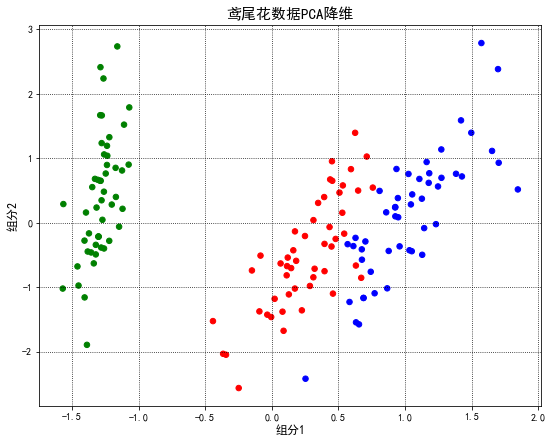

In [6]:
cm_light = mpl.colors.ListedColormap(['#77E0A0', '#FF8080', '#A0A0FF'])
cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])
mpl.rcParams['font.sans-serif'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(9, 7), facecolor='w')
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, marker='o', cmap=cm_dark)
plt.grid(b=True, ls=':', color='k')
plt.xlabel(x1_label, fontsize=12)
plt.ylabel(x2_label, fontsize=12)
plt.title(title, fontsize=15)
# plt.savefig('1.png')
plt.show()

In [8]:
# train and test
import warnings
warnings.filterwarnings("ignore")
x, x_test, y, y_test = train_test_split(x, y, train_size=0.7)
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=True)),
    ('lr', LogisticRegressionCV(Cs=np.logspace(-3, 4, 8), cv=5, fit_intercept=False))
])
model.fit(x, y)
print('最优参数：', model.get_params('lr')['lr'].C_)
y_hat = model.predict(x)
print('训练集精确度：', metrics.accuracy_score(y, y_hat))
y_test_hat = model.predict(x_test)
print('测试集精确度：', metrics.accuracy_score(y_test, y_test_hat))

最优参数： [  1.00000000e-03   1.00000000e+01   1.00000000e+00]
训练集精确度： 0.917808219178
测试集精确度： 0.90625


In [9]:
N, M = 500, 500     # 横纵各采样多少个值
x1_min, x1_max = extend(x[:, 0].min(), x[:, 0].max())   # 第0列的范围
x2_min, x2_max = extend(x[:, 1].min(), x[:, 1].max())   # 第1列的范围
t1 = np.linspace(x1_min, x1_max, N)
t2 = np.linspace(x2_min, x2_max, M)
x1, x2 = np.meshgrid(t1, t2)                    # 生成网格采样点
x_show = np.stack((x1.flat, x2.flat), axis=1)   # 测试点
y_hat = model.predict(x_show)  # 预测值
y_hat = y_hat.reshape(x1.shape)  # 使之与输入的形状相同

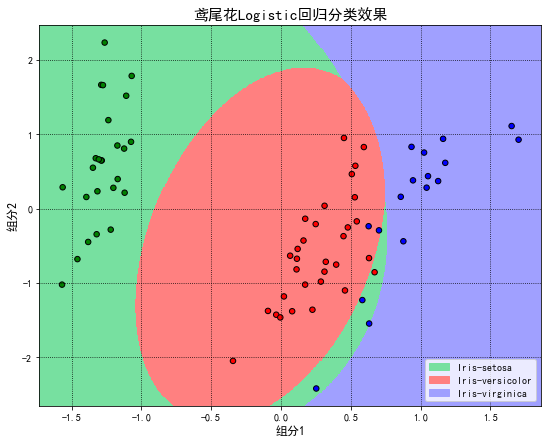

In [10]:
plt.figure(figsize=(9, 7), facecolor='w')
plt.pcolormesh(x1, x2, y_hat, cmap=cm_light)  # 预测值的显示
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, edgecolors='k', cmap=cm_dark)  # 样本的显示
plt.xlabel(x1_label, fontsize=12)
plt.ylabel(x2_label, fontsize=12)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.grid(b=True, ls=':', color='k')
# 画各种图
# a = mpl.patches.Wedge(((x1_min+x1_max)/2, (x2_min+x2_max)/2), 1.5, 0, 360, width=0.5, alpha=0.5, color='r')
# plt.gca().add_patch(a)
patchs = [mpatches.Patch(color='#77E0A0', label='Iris-setosa'),
          mpatches.Patch(color='#FF8080', label='Iris-versicolor'),
          mpatches.Patch(color='#A0A0FF', label='Iris-virginica')]
plt.legend(handles=patchs, fancybox=True, framealpha=0.8, loc='lower right')
plt.title('鸢尾花Logistic回归分类效果', fontsize=15)
plt.show()